In [2]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 27.1 MB/s 
     |████████████████████████████████| 283 kB 71.4 MB/s 
     |████████████████████████████████| 100 kB 11.1 MB/s 
     |████████████████████████████████| 11.2 MB 55.2 MB/s 
     |████████████████████████████████| 78 kB 3.1 MB/s 
     |████████████████████████████████| 308 kB 72.8 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 209 kB 66.9 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 965 kB 74.6 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 112 kB 60.7 MB/s 
     |████████████████████████████████| 147 kB 32.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=924a28

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Descarga de datos
# ==============================================================================
arch = ('/content/drive/MyDrive/Colab Notebooks/completa.csv')
datos = pd.read_csv(arch, sep=',')
datos.info()
datos.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7246 non-null   int64  
 1   FECHA/HORA   7246 non-null   object 
 2   Dia          7246 non-null   int64  
 3   TOTAL KW     7246 non-null   int64  
 4   TEMPERATURA  7246 non-null   float64
 5   Feriado      7246 non-null   int64  
 6   Publico      7246 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 396.4+ KB


,ID,FECHA/HORA,Dia,TOTAL KW,TEMPERATURA,Feriado,Publico
0,0,01/07/2021 00:00,4,1721748533,8.7,0,0
1,1,01/07/2021 01:00,4,1731462994,8.4,0,0
2,2,01/07/2021 02:00,4,1676358588,8.2,0,0
3,3,01/07/2021 03:00,4,1653972981,7.7,0,0
4,4,01/07/2021 04:00,4,1653886127,7.2,0,0


In [7]:
datos['Dia'].value_counts()

4    1056
5    1055
7    1032
1    1032
3    1032
2    1031
6    1008
Name: Dia, dtype: int64

In [8]:
datos['TOTAL KW'] = pd.to_numeric(datos['TOTAL KW'],errors = 'coerce')
datos.info()
datos.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7246 non-null   int64  
 1   FECHA/HORA   7246 non-null   object 
 2   Dia          7246 non-null   int64  
 3   TOTAL KW     7246 non-null   int64  
 4   TEMPERATURA  7246 non-null   float64
 5   Feriado      7246 non-null   int64  
 6   Publico      7246 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 396.4+ KB


,ID,FECHA/HORA,Dia,TOTAL KW,TEMPERATURA,Feriado,Publico
0,0,01/07/2021 00:00,4,1721748533,8.7,0,0
1,1,01/07/2021 01:00,4,1731462994,8.4,0,0
2,2,01/07/2021 02:00,4,1676358588,8.2,0,0


In [9]:


datos.rename(columns={'TOTAL KW':'TOTAL_KW'}, inplace=True)
datos.head(3)

,ID,FECHA/HORA,Dia,TOTAL_KW,TEMPERATURA,Feriado,Publico
0,0,01/07/2021 00:00,4,1721748533,8.7,0,0
1,1,01/07/2021 01:00,4,1731462994,8.4,0,0
2,2,01/07/2021 02:00,4,1676358588,8.2,0,0


In [10]:
# Conversión del formato fecha
# ==============================================================================
#datos['FECHA/HORA'] = pd.to_datetime(datos['FECHA/HORA'], format='%Y/%m/%dT%H:%M:%Sz')
datos['FECHA/HORA'] = pd.to_datetime(datos['FECHA/HORA'])
#datos['FECHA/HORA'] = datos['FECHA/HORA'].dt.strftime('%Y/%m/%dT%H:%M:%Sz')
datos = datos.set_index('FECHA/HORA')
datos = datos.asfreq('60min')
datos = datos.sort_index()
datos

,ID,Dia,TOTAL_KW,TEMPERATURA,Feriado,Publico
FECHA/HORA,,,,,,
2021-01-07 00:00:00,0.0,4.0,1.721749e+09,8.7,0.0,0.0
2021-01-07 01:00:00,1.0,4.0,1.731463e+09,8.4,0.0,0.0
2021-01-07 02:00:00,2.0,4.0,1.676359e+09,8.2,0.0,0.0
2021-01-07 03:00:00,3.0,4.0,1.653973e+09,7.7,0.0,0.0
2021-01-07 04:00:00,4.0,4.0,1.653886e+09,7.2,0.0,0.0
...,...,...,...,...,...,...
2022-12-04 19:00:00,6857.0,2.0,7.263328e+09,13.6,0.0,908.0
2022-12-04 20:00:00,6858.0,2.0,7.552296e+09,13.8,0.0,788.0
2022-12-04 21:00:00,6859.0,2.0,6.339663e+09,13.4,0.0,0.0


In [11]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [13]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2021-01-07 00:00:00': '2022-12-04 23:00:00']
fin_train = '2021-12-31 23:59:00'
fin_validacion = '2022-04-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
datos_train.head(3)


datos original
Fechas train      : 2021-01-07 00:00:00 --- 2021-12-31 23:00:00  (n=8616)
Fechas validacion : 2022-01-01 00:00:00 --- 2022-04-30 23:00:00  (n=2880)
Fechas test       : 2022-05-01 00:00:00 --- 2022-12-04 23:00:00  (n=5232)


,ID,Dia,TOTAL_KW,TEMPERATURA,Feriado,Publico
FECHA/HORA,,,,,,
2021-01-07 00:00:00,0.0,4.0,1.721749e+09,8.7,0.0,0.0
2021-01-07 01:00:00,1.0,4.0,1.731463e+09,8.4,0.0,0.0
2021-01-07 02:00:00,2.0,4.0,1.676359e+09,8.2,0.0,0.0


,ID,Dia,TOTAL_KW,TEMPERATURA,Feriado,Publico,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
FECHA/HORA,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
!pip install matplotlib==3.1.3



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 30.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skforecast 0.5.1 requires matplotlib<=3.5,>=3.3, but you have matplotlib 3.1.3 which is incompatible.


In [15]:
import matplotlib.pyplot as plt

In [16]:
from sklearn.model_selection import train_test_split

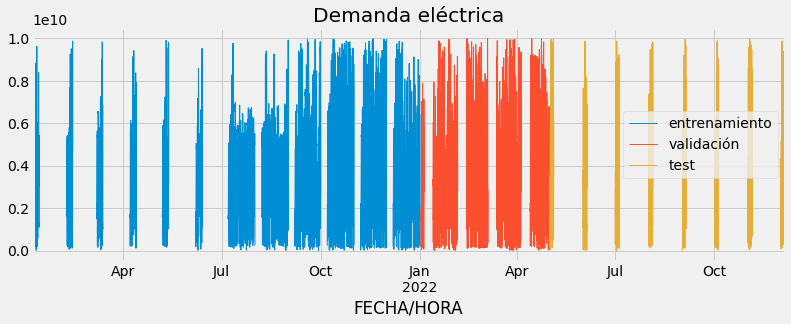

In [17]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.TOTAL_KW.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.TOTAL_KW.plot(ax=ax, label='validación', linewidth=1)
datos_test.TOTAL_KW.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

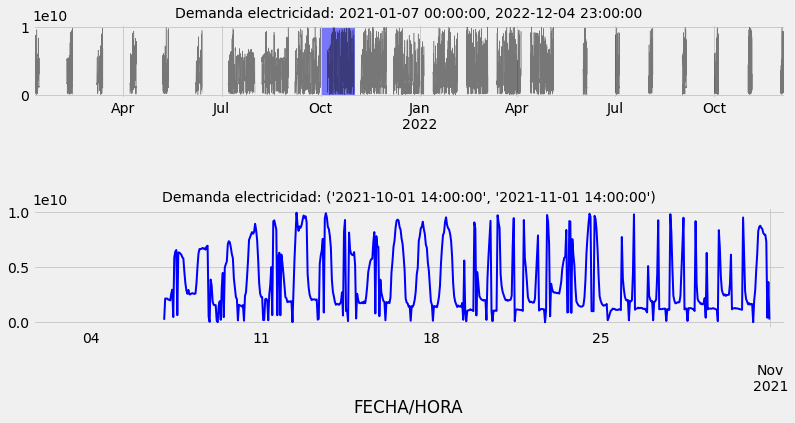

In [18]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2021-10-01 14:00:00','2021-11-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.TOTAL_KW.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.TOTAL_KW)
max_y = max(datos.TOTAL_KW)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].TOTAL_KW.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

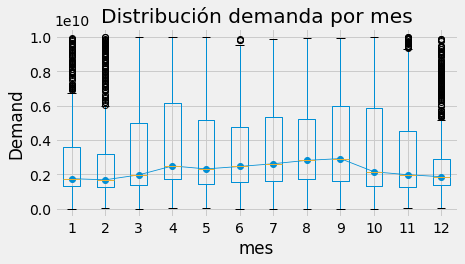

In [19]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='TOTAL_KW', by='mes', ax=ax,)
datos.groupby('mes')['TOTAL_KW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

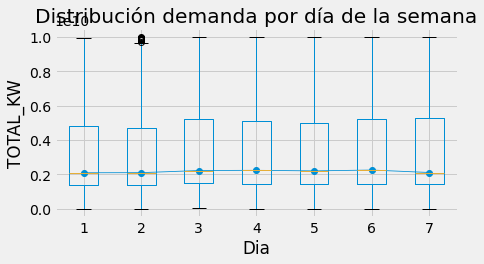

In [20]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['Dia'] = datos.index.day_of_week + 1
datos.boxplot(column='TOTAL_KW', by='Dia', ax=ax)
datos.groupby('Dia')['TOTAL_KW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('TOTAL_KW')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

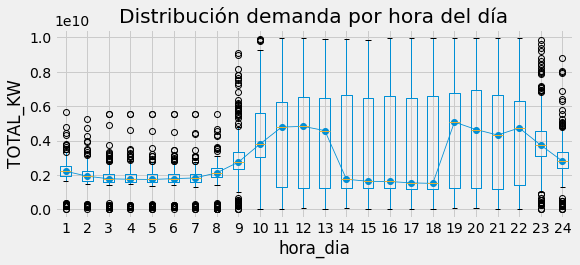

In [21]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='TOTAL_KW', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['TOTAL_KW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('TOTAL_KW')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

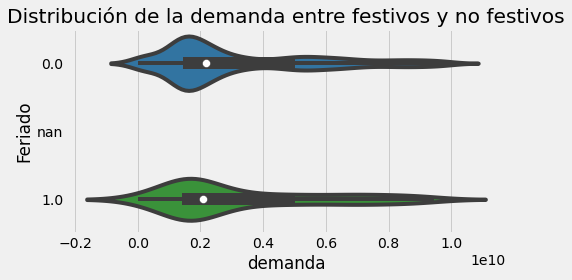

In [23]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'TOTAL_KW',
    y       = 'Feriado',
    data    = datos.assign(Feriado = datos.Feriado.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('Feriado');

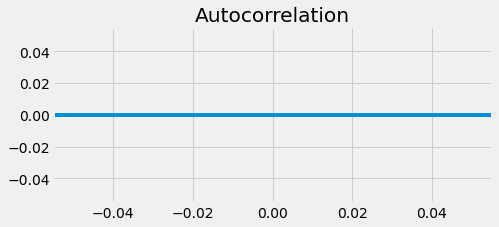

In [24]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.TOTAL_KW, ax=ax, lags=60)
plt.show()

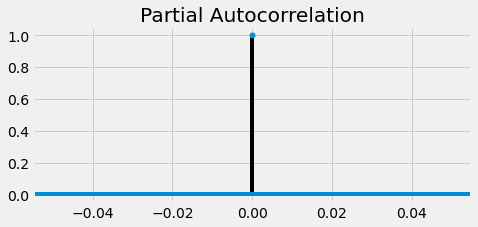

In [25]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.TOTAL_KW, ax=ax, lags=60)
plt.show()


In [29]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion,'TOTAL_KW'])
forecaster

TypeError: ignored

In [ ]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.TOTAL_KW,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Exception: ignored

NameError: ignored

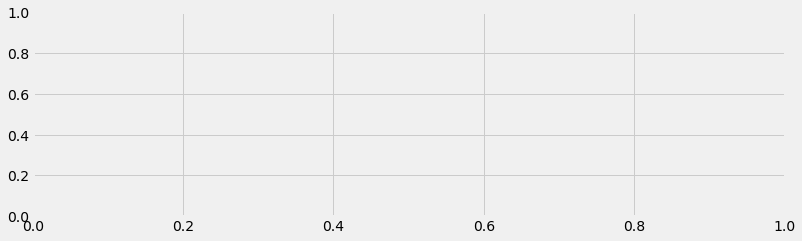

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL_KW'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

NameError: ignored

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()# Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'TOTAL KW'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(datos[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                  )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

In [ ]:
forecaster

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.Demand,
                            initial_train_size = len(datos[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            verbose            = False
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

In [ ]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos.Demand,
                            initial_train_size  = len(datos.Demand[:fin_validacion]),
                            fixed_train_size    = False,
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

print('Métrica backtesting:', metric)
predicciones.head(5)

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción' 
)
ax.legend();

In [ ]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[fin_validacion:, 'TOTAL KW'] >= predicciones['lower_bound']) & \
                     (datos.loc[fin_validacion:, 'TOTAL KW'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

In [ ]:
def backtest_predict_next_24h(forecaster, y, hour_init_prediction, exog=None,
                              verbose=False):
    
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg 
        ForecasterAutoreg object already trained.
        
    y : pd.Series with datetime index sorted
        Test time series values. 
        
    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable. 
    
    hour_init_prediction: int 
        Hour of day D to start predicciones of day D+1.


    Returns 
    -------
    predicciones: pd.Series
        Value of predicciones.

    '''
    
    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()
        
    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24
    
    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break
    
    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predicciones = []
    
    for i, day in enumerate(days_backtest):        
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]
               
        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")
                
            pred = forecaster.predict(steps=steps, last_window=last_window)
            
        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window
            
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")
            
            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predicciones of day D+1
        pred = pred[dummy_steps:]
        backtest_predicciones.append(pred)
    
    backtest_predicciones = np.concatenate(backtest_predicciones)
    # Add datetime index
    backtest_predicciones = pd.Series(
                             data  = backtest_predicciones,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )
    
    return backtest_predicciones

In [ ]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    hour_init_prediction = 11,
                    verbose    = False
                )

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )
print(f"Error de backtest: {error}")

In [ ]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importance()

In [ ]:
# Se convierte la columna Holiday de boolean a integer
datos_train.loc[:,'Feriado'] = datos_train['Feriado'].astype(int)
datos_test.loc[:,'Feriado'] = datos_test['Feriado'].astype(int)

# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )



forecaster.fit(y=datos.Demand[:fin_validacion], exog=datos.Holiday[:fin_validacion])
forecaster

In [ ]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    exog       = datos.loc[fin_validacion:, 'Feriado'],
                    hour_init_prediction = 11,
                    verbose    = False
               )

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'TOTAL KW'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

In [ ]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos.loc[:,'Feriado_antes'] = datos['Feriado'].shift(24)
datos.loc[:,'Feriado_despues']   = datos['Feriado'].shift(-24)
datos=datos.dropna()

# One hot encoding del día de la semana y la hora del día
datos=pd.get_dummies(datos, columns=['dia_semana', 'hora_dia'])
datos.head(3)

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Feriado'))]
forecaster.fit(y=datos.Demand[: fin_validacion], exog=datos[exog][: fin_validacion])

# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'TOTAL KW'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Modelo direct multi-step


Los modelos ForecasterAutoreg siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir, lo que se conoce como direct multi-step forecasting. Si bien es computacionalmente más costosa que la recursiva, puesto que requiere entrenar múltiples modelos, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregDirect y pueden incluir también una o múltiples variables exógenas.

Entrenamiento y tuning del Forecaster


A diferencia de cuando se utiliza ForecasterAutoreg, en los modelos de tipo ForecasterAutoregDirect hay que indicar, en el momento de su creación, el número máximo de steps que se quieren predecir.

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor = LGBMRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'TOTAL KW'],
                        exog               = datos.loc[:fin_validacion, exog],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        initial_train_size = len(datos.loc[:fin_train]),
                        return_best        = True,
                        verbose            = False
                  )

In [ ]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'TOTAL KW'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'TOTAL KW'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'TOTAL KW'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")